In [5]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [78]:
class PerfCnt:
    pass

class Hyper:
    def __repr__(self):
        return \
            " <" + str(self.BS_l)+" "+str(self.BS_j)+" "+str(self.BS_p)+"|"+\
                   str(self.TS_l)+" "+str(self.TS_j)+"> "+\
            "<<<1,"+str(self.dim)+","+str(self.sh_mem[-1])+">>>"

def strange_GEMM( sKa, sKb, sKc, sKd, inp, hyper, ref ):
    
    perf_cnt = PerfCnt()
    nla,npa = sKa.shape
    nlb,npb = sKb.shape
    nlc,npc = sKc.shape
    nld,npd = sKd.shape
    n_prm, NC = inp.shape
    nlabcd = nla*nlb*nlc*nld
        
    TS_l = hyper.TS_l
    TS_j = hyper.TS_j
    F1 = hyper.F1
    F2 = hyper.F2
    BS_p = hyper.BS_p
    
    dim = F1*F2
    BS_l = F1 * TS_l
    BS_j = F2 * TS_j
    
    hyper.dim  = dim
    hyper.BS_l = BS_l
    hyper.BS_j = BS_j
    
    totResBlkT = BS_l * BS_j
    numThrBlkT = totResBlkT // (TS_l*TS_j)
    strideK = numThrBlkT // BS_p # = BS_l * BS_j / (TS_l*TS_j)
    strideI = numThrBlkT // BS_j

    perf_cnt.wrote_O_by = defaultdict(list)
    perf_cnt.wrote_sK_by = defaultdict(list)
    perf_cnt.read_K = np.zeros((nlabcd,n_prm))
    perf_cnt.read_I = np.zeros((n_prm,NC))
    perf_cnt.wrote_O = np.zeros((nlabcd,NC))
    perf_cnt.dim = dim
    
    sK = np.random.uniform(size=BS_l*BS_p)#.reshape((BS_l,BS_p))
    sI = np.random.uniform(size=BS_p*BS_j)#.reshape((BS_p,BS_j))

    k_comp = 0
    ki_comp = 0
    out = np.zeros((nlabcd,NC))

    tCol = np.zeros(dim,dtype=int)
    tRow = np.zeros(dim,dtype=int)
    iRoK = np.zeros(dim,dtype=int)
    iCoK = np.zeros(dim,dtype=int)
    iRoI = np.zeros(dim,dtype=int)
    iCoI = np.zeros(dim,dtype=int)

    # thr private idx
    for thr in range(dim):
        tRow[thr] = thr // (BS_j // TS_j)
        tCol[thr] = thr  % (BS_j // TS_j)
        assert(tRow[thr]*(BS_j // TS_j) + tCol[thr] == thr )

        iRoK[thr] = thr // BS_p
        iCoK[thr] = thr  % BS_p
        assert(iRoK[thr]*BS_p + iCoK[thr] == thr )

        iRoI[thr] = thr // BS_j
        iCoI[thr] = thr  % BS_j
        assert(iRoI[thr]*BS_j + iCoI[thr] == thr )    
        
    sh_mem = ((BS_l,BS_p), (BS_p,BS_j), (dim,6), (dim,TS_l,TS_j), (BS_l*BS_p+BS_p*BS_j+dim*6+dim*TS_l*TS_j))
    perf_cnt.sh_mem = sh_mem
    hyper.sh_mem = sh_mem
    
    if hyper.iw > 0:
        print( "computing<",BS_l,BS_j,BS_p,"|",TS_l,TS_j,"||",strideK,strideI,"> <<<",1,dim,sh_mem,">>>", nlabcd, NC, n_prm)


    assert( numThrBlkT == dim )
    assert( BS_l * BS_p >= dim )
    assert( BS_p * BS_j >= dim )
    assert( strideK > 0 )
    assert( strideI > 0 )

    regL = np.zeros( (dim,TS_l))
    regJ = np.zeros( (dim,TS_j))

    for IB_l in range( 0, (nlabcd+BS_l-1) // BS_l ):
        #
        for IB_p in range( 0, (n_prm+BS_p-1) // BS_p ):

            l_min = iRoK[0 ] + 0    + IB_l * BS_l
            l_max = iRoK[-1] + BS_l + IB_l * BS_l
            p_min = iCoK[0 ] + IB_p * BS_p
            p_max = iRoK[-1] + IB_p * BS_p
            if hyper.iw > 1:
                print( IB_l, IB_p, "loading K " , l_min, l_max, ",", p_min, p_max )

            # essentially a load of A in shared memory with a few complications
            for offK in range(0, BS_l, strideK):
                written_sK = np.zeros((BS_l,BS_p))
                for thr in range(dim):

                    iB_l = iRoK[thr] + offK
                    iB_p = iCoK[thr]

                    l  = iRoK[thr] + offK + IB_l * BS_l
                    p  = iCoK[thr] + IB_p * BS_p

                    if p < n_prm and l < nlabcd:
                        ila = l // (nlb*nlc*nld) % nla
                        ilb = l // (nlc*nld) % nlb
                        ilc = l // (nld) % nlc
                        ild = l % nld
                        ipa,ipb,ipc,ipd = PMX[p]
                        K = sKa[ ila, ipa ] * sKb[ ilb, ipb ] * sKc[ ilc, ipc ] * sKd[ ild, ipd ]
                        sK[iB_l*BS_p+iB_p] = K
                        written_sK[iB_l,iB_p] += 1
                        perf_cnt.wrote_sK_by[iB_l,iB_p].append(thr)
                        perf_cnt.read_K[l,p] += 1
                        k_comp += 1
                    else:
                        sK[iB_l*BS_p+iB_p] = 0.0

                assert( np.all(written_sK <= 1 ))

            # essentially a load of B in shared memory with a few complications
            for IB_j in range( 0, (NC+BS_j-1) // BS_j ):

                p_min = iRoI[0 ] + 0    + IB_p * BS_p
                p_max = iRoI[-1] + BS_p + IB_p * BS_p
                j_min = iCoI[0 ]        + IB_j * BS_j
                j_max = iCoI[-1]        + IB_j * BS_j
                if hyper.iw > 1:
                    print( IB_l, IB_p, IB_j, "   loading I " , p_min, p_max, ",", j_min, j_max )
                # load B in shared memory
                for offI in range(0, BS_p, strideI):
                    for thr in range(dim):
                        iB_p = iRoI[thr] + offI
                        iB_j = iCoI[thr]

                        p = iRoI[thr] + offI + IB_p * BS_p
                        j = iCoI[thr]        + IB_j * BS_j

                        if p < n_prm and j < NC:
                            sI[iB_p*BS_j+iB_j] = inp[p,j]
                            perf_cnt.read_I[p,j] += 1
                        else :
                            sI[iB_p*BS_j+iB_j] = 0.

                # __sync after writing sI, will mean sync after sK

                if hyper.iw > 1:
                    print( IB_l, IB_p, IB_j, "   computing Res " , l_min, l_max, ",", j_min, j_max, " = sum ", p_min,p_max )
                tRes = np.zeros( (dim,TS_l*TS_j) )
                for thr in range(dim):
                    for iB_p in range( BS_p ):
                        for iT_l in range( TS_l ):
                            regL[thr,iT_l] = sK[ (tRow[thr] * TS_l + iT_l) * BS_p + iB_p ]
                        for iT_j in range( TS_j ):
                            regJ[thr,iT_j] = sI[ iB_p * BS_j + tCol[thr] * TS_j + iT_j ]

                        for res_l in range( TS_l ):
                            for res_j in range( TS_j ):
                                tRes[thr, res_l*TS_j+res_j] += regL[thr,res_l] * regJ[thr,res_j]

                    for res_l in range( TS_l ):
                        for res_j in range( TS_j ):
                            l = tRow[thr] * TS_l + res_l + IB_l * BS_l
                            j = tCol[thr] * TS_j + res_j + IB_j * BS_j
                            if l < nlabcd and j < NC:
                                out[l,j] += tRes[thr,res_l*TS_j+res_j]
                                perf_cnt.wrote_O[l,j] += 1
                                perf_cnt.wrote_O_by[(l,j)].append(thr)

                # __sync after using sI and sK


    if not np.allclose(perf_cnt.read_K,1.0):
        print("Orange alert! K computed more than once", out, ref)
    
    if not np.allclose(out,ref):
        print("Red alert! wrong answer detected", out, ref)
        
    assert(np.allclose(out,ref))
    
    perf_cnt.thr_write_sK_cnt = np.zeros(dim,int)
    for k in perf_cnt.wrote_sK_by:
        for t in perf_cnt.wrote_sK_by[k]:
            assert( t == perf_cnt.wrote_sK_by[k][0])
            perf_cnt.thr_write_sK_cnt[t] += 1
            
    perf_cnt.thr_write_O_cnt = np.zeros(dim,int)
    for k in perf_cnt.wrote_O_by:
        for t in perf_cnt.wrote_O_by[k]:
            assert( t == perf_cnt.wrote_O_by[k][0])
            perf_cnt.thr_write_O_cnt[t] += 1
    return perf_cnt

In [97]:
rng = np.random.default_rng(44)

NC = 45

nla,nlb,nlc,nld = 3,3,3,2
npa,npb,npc,npd = 2,3,6,3
nlabcd = nla*nlb*nlc*nld
n_prm0 = npa*npb * npc*npd
n_prm = 0
PMX = []

for ipa in range(npa):
    for ipb in range(npb):
        for ipc in range(npc):
            for ipd in range(npd):
                r = rng.random()
                if r < 0.7:
                    n_prm += 1
                    PMX.append([ipa,ipb,ipc,ipd])
PMX = np.array(PMX)
print( nlabcd, NC, n_prm0, "->", n_prm )

sKa = rng.random( npa * nla ).reshape((nla,npa))
sKb = rng.random( npb * nlb ).reshape((nlb,npb))
sKc = rng.random( npc * nlc ).reshape((nlc,npc))
sKd = rng.random( npd * nld ).reshape((nld,npd))

inp = rng.random( n_prm * NC ).reshape((n_prm,NC))
#plt.imshow(inp)
#plt.show()

k_comp = 0
ref = np.zeros((nlabcd,NC))
## Simple, slow loop with compute K in the core loop
for l in range(nlabcd):
    for j in range(NC):
        tmp = 0.0
        for p in range(n_prm):
            ila = l // (nlb*nlc*nld) % nla
            ilb = l // (nlc*nld) % nlb
            ilc = l // (nld) % nlc
            ild = l % nld
            ipa,ipb,ipc,ipd = PMX[p]
            K = sKa[ ila, ipa ] * sKb[ ilb, ipb ] * sKc[ ilc, ipc ] * sKd[ ild, ipd ]
            k_comp += 1
            tmp += K * inp[ p, j ]
        ref[l,j] = tmp
#plt.imshow(ref)
#plt.show()
#print(k_comp)



54 45 108 -> 70


computing< 16 32 8 | 2 4 || 8 2 > <<< 1 64 ((16, 8), (8, 32), (64, 6), (64, 2, 4), 1280) >>> 54 45 70
computing< 32 64 8 | 2 4 || 32 4 > <<< 1 256 ((32, 8), (8, 64), (256, 6), (256, 2, 4), 4352) >>> 54 45 70
computing< 64 128 8 | 2 4 || 128 8 > <<< 1 1024 ((64, 8), (8, 128), (1024, 6), (1024, 2, 4), 15872) >>> 54 45 70
Invalid hyper conf  <64 128 8|2 4> <<<1,1024,15872>>>


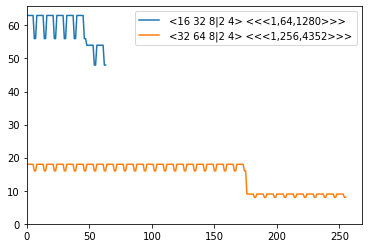

In [95]:

for F in [8,16,32]:

    hyper = Hyper()
    hyper.TS_l = 2
    hyper.TS_j = 4
    hyper.F1   = F
    hyper.F2   = F
    hyper.BS_p = 8
    hyper.iw = 1

    try:
        p1 = strange_GEMM(sKa,sKb,sKc,sKd,inp,hyper,ref)
    except :
        print("Invalid hyper conf", hyper)
    else:
        plt.plot(p1.thr_write_sK_cnt, label=hyper)
        
plt.xlim(0,)
plt.ylim(0,)
plt.legend()
plt.show()

#        plt.plot(p1.thr_write_O_cnt)
#        plt.xlim(0,p1.dim)
#        plt.ylim(0,)
#        plt.show()


In [96]:
######################################################################################

In [ ]:
k_comp = 0
ref = np.zeros((nlabcd,NC))
## Simple, slow loop with compute K in the core loop
for l in range(nlabcd):
    for j in range(NC):
        tmp = 0.0
        for p in range(n_prm):
            ila = l // (nlb*nlc*nld) % nla
            ilb = l // (nlc*nld) % nlb
            ilc = l // (nld) % nlc
            ild = l % nld
            ipa,ipb,ipc,ipd = PMX[p]
            K = sKa[ ila, ipa ] * sKb[ ilb, ipb ] * sKc[ ilc, ipc ] * sKd[ ild, ipd ]
            k_comp += 1
            tmp += K * inp[ p, j ]
        ref[l,j] = tmp
plt.imshow(ref)
plt.show()
print(k_comp)
print(nlabcd, n_prm)

In [ ]:
# Standard-ish triple tile gemm with K in the inner loop
# We move K to the inner loop to reuse calculations of K
TS_p = 3
TS_l = 5
TS_j = 7
sK = np.random.uniform(size=TS_l*TS_p).reshape((TS_l,TS_p))
sI = np.random.uniform(size=TS_p*TS_j).reshape((TS_p,TS_j))
sO = np.random.uniform(size=TS_l*TS_j).reshape((TS_l,TS_j))

regK = np.random.uniform(size=TS_l).reshape((TS_l))
regI = np.random.uniform(size=TS_j).reshape((TS_j))

k_comp = 0
ki_comp = 0
out = np.zeros((nlabcd,NC))

for IT_l in range( 0, (nlabcd+TS_l-1) // TS_l ):
    for IT_p in range( 0, (n_prm+TS_p-1) // TS_p ):

        # essentially a load of A in shared memory with a few complications
        sK *= 0.0
        for iT_l in range(TS_l):
            l = IT_l * TS_l + iT_l
            ila = l // (nlb*nlc*nld) % nla
            ilb = l // (nlc*nld) % nlb
            ilc = l // (nld) % nlc
            ild = l % nld
            # shared compute of K
            for iT_p in range(TS_p):
                p = IT_p * TS_p + iT_p
                if p < n_prm and l < nlabcd:
                    ipa,ipb,ipc,ipd = PMX[p]
                    K = sKa[ ila, ipa ] * sKb[ ilb, ipb ] * sKc[ ilc, ipc ] * sKd[ ild, ipd ]
                    k_comp += 1
                    sK[iT_l,iT_p] = K
                else:
                    sK[iT_l,iT_p] = 0.0

        # __sync
        
        for IT_j in range( 0, (NC+TS_j-1) // TS_j ):
            
            # essentially a load of B in shared memory
            sI *= 0.0
            for iT_p in range(TS_p):
                p = IT_p * TS_p + iT_p
                if p < n_prm:
                    for iT_j in range(TS_j):
                        j = IT_j * TS_j + iT_j
                        if j < NC:        
                            sI[iT_p,iT_j] = inp[ p, j ]
                            
            # __sync
            
            # computes C tile in shared memory
            sO *= 0.0
            for iT_p in range(TS_p):
                for iT_l in range(TS_l):
                    regK[iT_l] = sK[iT_l,iT_p]
                for iT_j in range(TS_j):
                    regI[iT_j] = sI[iT_p,iT_j]
                    
                for iT_l in range(TS_l):
                    for iT_j in range(TS_j):
                        sO[iT_l,iT_j] += regK[iT_l] * regI[iT_j]
                        ki_comp+= 1
                            
            # __sync
            
            # writes C from shared to global
            for iT_l in range(TS_l):
                l = IT_l * TS_l + iT_l
                if l < nlabcd:
                    for iT_j in range(TS_j):
                        j = IT_j * TS_j + iT_j
                        if j < NC:        
                            out[l,j] += sO[iT_l,iT_j]
                            
            # __sync
            
        # __sync

print('Max diff : ', np.max(np.abs(out-ref)))
print(k_comp, ki_comp)
plt.imshow(out)
plt.show()
plt.imshow(out - ref)
plt.show()

In [ ]:
# Triple block-tile gemm + inner thread tile with K in the inner loop
# We move K to the inner loop to reuse calculations of K

read_K = np.zeros((nlabcd,n_prm))
read_I = np.zeros((n_prm,NC))
wrote_O = np.zeros((nlabcd,NC))
from collections import defaultdict
wrote_O_by = defaultdict(list)
wrote_sK_by = defaultdict(list)

TS_l = 2
TS_j = 2

F1 = 8
F2 = 8
BS_p = 8

dim = F1*F2
BS_l = F1 * TS_l
BS_j = F2 * TS_j
totResBlkT = BS_l * BS_j
numThrBlkT = totResBlkT // (TS_l*TS_j)
strideK = numThrBlkT // BS_p # = BS_l * BS_j / (TS_l*TS_j)
strideI = numThrBlkT // BS_j

sK = np.random.uniform(size=BS_l*BS_p)#.reshape((BS_l,BS_p))
sI = np.random.uniform(size=BS_p*BS_j)#.reshape((BS_p,BS_j))

k_comp = 0
ki_comp = 0
out = np.zeros((nlabcd,NC))




tCol = np.zeros(dim,dtype=int)
tRow = np.zeros(dim,dtype=int)
iRoK = np.zeros(dim,dtype=int)
iCoK = np.zeros(dim,dtype=int)
iRoI = np.zeros(dim,dtype=int)
iCoI = np.zeros(dim,dtype=int)

# thr private idx
for thr in range(dim):
    tRow[thr] = thr // (BS_j // TS_j)
    tCol[thr] = thr  % (BS_j // TS_j)
    assert(tRow[thr]*(BS_j // TS_j) + tCol[thr] == thr )
    
    iRoK[thr] = thr // BS_p
    iCoK[thr] = thr  % BS_p
    assert(iRoK[thr]*BS_p + iCoK[thr] == thr )
    
    iRoI[thr] = thr // BS_j
    iCoI[thr] = thr  % BS_j
    assert(iRoI[thr]*BS_j + iCoI[thr] == thr )

    
sh_mem = ((BS_l,BS_p), (BS_p,BS_j), (dim,6), (dim,TS_l,TS_j), (BS_l*BS_p+BS_p*BS_j+dim*6+dim*TS_l*TS_j))
print( "computing<",BS_l,BS_j,BS_p,"|",TS_l,TS_j,"||",strideK,strideI,"> <<<",1,dim,sh_mem,">>>", nlabcd, ",", NC, " = ", nlabcd, ",", n_prm, "@", n_prm, ",", NC)


assert( numThrBlkT == dim )
assert( BS_l * BS_p >= dim )
assert( BS_p * BS_j >= dim )
assert( strideK > 0 )
assert( strideI > 0 )

regL = np.zeros( (dim,TS_l))
regJ = np.zeros( (dim,TS_j))

for IB_l in range( 0, (nlabcd+BS_l-1) // BS_l ):
    #
    for IB_p in range( 0, (n_prm+BS_p-1) // BS_p ):
        
        l_min = iRoK[0 ] + 0    + IB_l * BS_l
        l_max = iRoK[-1] + BS_l + IB_l * BS_l
        p_min = iCoK[0 ] + IB_p * BS_p
        p_max = iRoK[-1] + IB_p * BS_p
        print( IB_l, IB_p, "loading K " , l_min, l_max, ",", p_min, p_max )
        
        # essentially a load of A in shared memory with a few complications
        for offK in range(0, BS_l, strideK):
            written_sK = np.zeros((BS_l,BS_p))
            for thr in range(dim):
                
                iB_l = iRoK[thr] + offK
                iB_p = iCoK[thr]
               
                l  = iRoK[thr] + offK + IB_l * BS_l
                p  = iCoK[thr] + IB_p * BS_p
                
                if p < n_prm and l < nlabcd:
                    ila = l // (nlb*nlc*nld) % nla
                    ilb = l // (nlc*nld) % nlb
                    ilc = l // (nld) % nlc
                    ild = l % nld
                    ipa,ipb,ipc,ipd = PMX[p]
                    K = sKa[ ila, ipa ] * sKb[ ilb, ipb ] * sKc[ ilc, ipc ] * sKd[ ild, ipd ]
                    sK[iB_l*BS_p+iB_p] = K
                    written_sK[iB_l,iB_p] += 1
                    wrote_sK_by[iB_l,iB_p].append(thr)
                    read_K[l,p] += 1
                    k_comp += 1
                else:
                    sK[iB_l*BS_p+iB_p] = 0.0
                    
            assert( np.all(written_sK <= 1 ))

        # essentially a load of B in shared memory with a few complications
        for IB_j in range( 0, (NC+BS_j-1) // BS_j ):
            
            p_min = iRoI[0 ] + 0    + IB_p * BS_p
            p_max = iRoI[-1] + BS_p + IB_p * BS_p
            j_min = iCoI[0 ]        + IB_j * BS_j
            j_max = iCoI[-1]        + IB_j * BS_j
            print( IB_l, IB_p, IB_j, "   loading I " , p_min, p_max, ",", j_min, j_max )
            # load B in shared memory
            for offI in range(0, BS_p, strideI):
                for thr in range(dim):
                    iB_p = iRoI[thr] + offI
                    iB_j = iCoI[thr]
                    
                    p = iRoI[thr] + offI + IB_p * BS_p
                    j = iCoI[thr]        + IB_j * BS_j
                    
                    if p < n_prm and j < NC:
                        sI[iB_p*BS_j+iB_j] = inp[p,j]
                        read_I[p,j] += 1
                    else :
                        sI[iB_p*BS_j+iB_j] = 0.
                    
            # __sync after writing sI, will mean sync after sK
            
            print( IB_l, IB_p, IB_j, "   computing Res " , l_min, l_max, ",", j_min, j_max, " = sum ", p_min,p_max )
            tRes = np.zeros( (dim,TS_l*TS_j) )
            for thr in range(dim):
                for iB_p in range( BS_p ):
                    for iT_l in range( TS_l ):
                        regL[thr,iT_l] = sK[ (tRow[thr] * TS_l + iT_l) * BS_p + iB_p ]
                    for iT_j in range( TS_j ):
                        regJ[thr,iT_j] = sI[ iB_p * BS_j + tCol[thr] * TS_j + iT_j ]

                    for res_l in range( TS_l ):
                        for res_j in range( TS_j ):
                            tRes[thr, res_l*TS_j+res_j] += regL[thr,res_l] * regJ[thr,res_j]

                for res_l in range( TS_l ):
                    for res_j in range( TS_j ):
                        l = tRow[thr] * TS_l + res_l + IB_l * BS_l
                        j = tCol[thr] * TS_j + res_j + IB_j * BS_j
                        if l < nlabcd and j < NC:
                            out[l,j] += tRes[thr,res_l*TS_j+res_j]
                            wrote_O[l,j] += 1
                            wrote_O_by[(l,j)].append(thr)
                            
            # __sync after using sI and sK


assert(np.allclose(read_K,1.0))

print('Max diff : ', np.max(np.abs(out-ref)))
print(k_comp, ki_comp)
plt.imshow(out)
plt.show()
plt.imshow(out - ref)
plt.show()

plt.imshow(read_I)
plt.show()

plt.imshow(wrote_O)
plt.show()

print(np.max(read_I))
print(np.max(read_K))

In [ ]:
(nlabcd+BS_l-1) // BS_l

In [ ]:
(n_prm+BS_p-1) // BS_p

In [ ]:
for offK in range(0, BS_l, strideK):
    print(offK)

In [ ]:
written_sK